In [56]:
import epmwebapi as epm
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set(style="whitegrid")
%matplotlib inline

In [57]:
import os
credentials = os.environ.get('user_and_password_dili').split(';')
user = credentials[0]
password = credentials[1]

In [58]:
#cria conexao
epmConn = epm.EpmConnection('http://dili:44333', 'http://dili:44332', user, password)

#3 porque dados estão em UTC no server
iniTime = dt.datetime(2018, 9, 24, 3, 0, 0, 0)
endTime = iniTime + dt.timedelta(days=5)

list_df = []

paths = ['ADM_Temperature', 'ADM_TemperatureSP', 'ADM_ACCompr', 'ADM_ACVent']

processInterval = dt.timedelta(minutes=10)

#cria objeto queryperiod
queryPeriod = epm.QueryPeriod(iniTime, endTime)

aggInterpDetails = epm.AggregateDetails(processInterval, epm.AggregateType.Interpolative)
aggTimeAvgDetails = epm.AggregateDetails(processInterval, epm.AggregateType.TimeAverage)

for path in paths:
        
    bv = epmConn.getDataObjects(path)

    if path == 'ADM_Temperature':
        result= bv[path].historyReadAggregate(aggTimeAvgDetails, queryPeriod)
    else:
        result= bv[path].historyReadAggregate(aggInterpDetails, queryPeriod)
    
    #======================================================================================
    # Transformação em DataFrame do pandas
    #======================================================================================
    #corrige o erro: ValueError: Big-endian buffer not supported on little-endian compiler
    new_Quality = result[:]['Quality'].byteswap().newbyteorder()
    new_Timestamp = result[:]['Timestamp']
    new_Value = result[:]['Value'].byteswap().newbyteorder()

    d = {'Value':new_Value, 'Timestamp':new_Timestamp, 'Quality':new_Quality}
    df_original = pd.DataFrame(d)
    
    #======================================================================================
    # Converte de UTC PARA LOCALTIME
    #======================================================================================
    df_original['Timestamp'] = df_original['Timestamp'].dt.tz_convert('America/Sao_Paulo')
    
    #array de dataframes
    list_df.append(df_original)


epmConn.close()

In [81]:
type(list_df)

list

### Análise Conforto Térmico

Filtro para horário comercial

In [82]:
filtered_df = []

for df in list_df:

    mask = (
        (df.Timestamp.dt.hour.between(8,11) | (df.Timestamp.dt.hour.between(13,18) ))
        & (df.Quality == 0)
    )

    df_aux = df.loc[mask]
    filtered_df.append(df_aux)

In [83]:
type(filtered_df)

list

In [84]:
df_01 = filtered_df[0][['Timestamp']].copy()
df_01['Temperatura'] = filtered_df[0][['Value']].copy()
df_01['TemperaturaSP'] = filtered_df[1][['Value']].copy()
df_01['Compressor'] = filtered_df[2][['Value']].copy()
df_01['Ventilacao'] = filtered_df[3][['Value']].copy()

In [85]:
df_01.describe()

,Temperatura,TemperaturaSP,Compressor,Ventilacao
count,290.000000,177.000000,183.000000,192.000000
mean,25.593767,25.359320,0.158470,0.182292
std,0.463364,0.399766,0.366183,0.387094
min,24.387035,24.700001,0.000000,0.000000
25%,25.394437,25.000000,0.000000,0.000000
50%,25.666804,25.400000,0.000000,0.000000
75%,25.779814,25.799999,0.000000,0.000000
max,27.354706,25.799999,1.000000,1.000000


#### Classificação por faixas de conforto térmico
* Dentro da faixa -> temperatuas entre 24.5° e 25.5°
* Acima da faixa -> temperatuas maiores que 25.5°
* Abaixo da faixa -> temperatuas menores que 24.5°

In [86]:
def conforto(a):
    if a>=24.5 and a<=25.5:
        return 'dentro'
    if a<24.5:
        return 'abaixo'
    else:
        return 'acima'

In [87]:
df_01['conforto_termico'] = df_01.Temperatura.apply(conforto)

In [88]:
df_01.head()

,Timestamp,Temperatura,TemperaturaSP,Compressor,Ventilacao,conforto_termico
48,2018-09-24 08:00:00-03:00,25.141575,NaN,NaN,NaN,dentro
49,2018-09-24 08:10:00-03:00,25.142132,NaN,NaN,NaN,dentro
50,2018-09-24 08:20:00-03:00,25.175270,NaN,NaN,NaN,dentro
51,2018-09-24 08:30:00-03:00,25.260233,NaN,NaN,NaN,dentro
52,2018-09-24 08:40:00-03:00,25.298717,NaN,NaN,NaN,dentro


In [89]:
df_01.describe(include='all')

,Timestamp,Temperatura,TemperaturaSP,Compressor,Ventilacao,conforto_termico
count,290,290.000000,177.000000,183.000000,192.000000,290
unique,290,NaN,NaN,NaN,NaN,3
top,2018-09-28 10:40:00-03:00,NaN,NaN,NaN,NaN,acima
freq,1,NaN,NaN,NaN,NaN,192
mean,NaN,25.593767,25.359320,0.158470,0.182292,NaN
std,NaN,0.463364,0.399766,0.366183,0.387094,NaN
min,NaN,24.387035,24.700001,0.000000,0.000000,NaN
25%,NaN,25.394437,25.000000,0.000000,0.000000,NaN
50%,NaN,25.666804,25.400000,0.000000,0.000000,NaN
75%,NaN,25.779814,25.799999,0.000000,0.000000,NaN


In [90]:
grouped = df_01.groupby(['conforto_termico']).Temperatura.agg(['count', 'max', 'min'])
grouped

,count,max,min
conforto_termico,,,
abaixo,3,24.450279,24.387035
acima,192,27.354706,25.500261
dentro,95,25.496731,24.504059


In [91]:
def make_autopct(values):
    #values -> valores enviados
    def my_autopct(pct):
        #pct -> %
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

In [92]:
colors = ["#103547", "#296e8e", "#59a1c0", "#4F5559", "#7B858A", "#323531"]

(-1.25, 1.25, -1.25, 1.25)

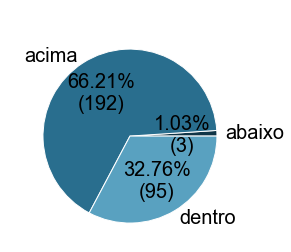

In [93]:
##plt.close()

sub_plot = df_01.groupby(['conforto_termico']).Temperatura.count().plot(
    kind='pie',  
    autopct=make_autopct(grouped['count']),
    colors=colors,
    textprops=dict(color="black", size= 20)
)
sub_plot.set_title('Conforto Térmico', size=20, color='white', weight="bold")
plt.axis('off')

In [94]:
grouped_01 = df_01.groupby(['conforto_termico', 'Compressor']).Compressor.agg(['count']).reset_index()
grouped_01

,conforto_termico,Compressor,count
0,abaixo,0.0,2
1,abaixo,1.0,1
2,acima,0.0,88
3,acima,1.0,8
4,dentro,0.0,64
5,dentro,1.0,20


In [73]:
grouped_01.loc[grouped_01.conforto_termico=='abaixo']['count'].sum()

3

In [74]:
grouped_01.conforto_termico.tolist()

['abaixo', 'abaixo', 'acima', 'acima', 'dentro', 'dentro']

In [75]:
grouped_01['count'].tolist()

[2, 1, 88, 8, 64, 20]

In [76]:
def make_autopct02(values):
    #values -> valores enviados
    def my_autopct(pct):
        #pct -> %
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

In [77]:
labels = ['abaixo', 'acima', 'dentro']
colors = ["#FF7033", "#005885", "#FF3300"]

acima_sum = grouped_01.loc[grouped_01.conforto_termico=='abaixo']['count'].sum()
abaixo_sum = grouped_01.loc[grouped_01.conforto_termico=='acima']['count'].sum()
dentro_sum = grouped_01.loc[grouped_01.conforto_termico=='dentro']['count'].sum()

sizes = [acima_sum, abaixo_sum, dentro_sum]

labels_compressor = grouped_01.conforto_termico.tolist()
sizes_compressor = grouped_01['count'].tolist()

labels_legend = ['Desligado', 'Ligado'] 
colors_compressor = ['#FFA166', '#0195D0']

explode = (0.2,0.2,0.2) 
explode_compressor = (0.1,0.65,0.1,0.65,0.1,0.65)

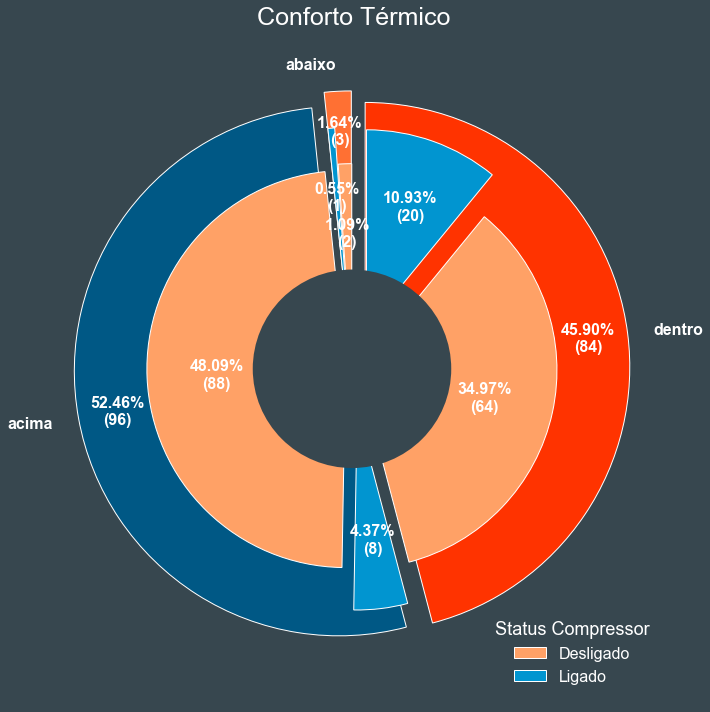

In [78]:
fig, ax = plt.subplots(figsize = (10,10),subplot_kw=dict(aspect="equal"))

#Plot
plt.pie(sizes, labels=labels, colors=colors, 
        startangle=90,
        frame=True, 
        explode=explode,
        radius=4,  
        autopct=make_autopct02(grouped_01['count']),
        textprops=dict(size= 16,weight='bold'),
        pctdistance=0.85,
        labeldistance=1.1,
       )

wedges, texts, autotexts = plt.pie(sizes_compressor, 
       # labels=labels_comp,
        colors=colors_compressor,
        startangle=90, 
        explode=explode_compressor,
        radius=3, 
        autopct=make_autopct02(grouped_01['count'] ),
        pctdistance=0.65,
        textprops=dict(size= 16, weight='bold'),
        #labeldistance=0.6,
        #edgeprops=dict(width=0.5)
       )

ax.legend(wedges,labels_legend, 
          title = 'Status Compressor',
          title_fontsize= 18,
          loc="lower right",
          facecolor='#37474F',
          edgecolor='#37474F',
          fontsize=16 ,
         )

# seta todas as fontes com branco
def myfunc(x):
    return hasattr(x, 'set_color') and not hasattr(x, 'set_facecolor')
for o in fig.findobj(myfunc):
    o.set_color('white')

centre_circle = plt.Circle((0,0),1.5,color='black', fc='#37474F',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 

ax.set_title("Conforto Térmico", fontsize=25, color='white')

fig.set_facecolor('#37474F')

plt.axis('equal')
plt.tight_layout()
plt.show()

In [79]:
from io import BytesIO
import mimetypes
import time

In [80]:
#cria conexao
epmConn = epm.EpmConnection('http://localhost:44333', 'http://localhost:44332', 'sa', 'Elipse21')
sio = BytesIO() 
fig.savefig(sio, format="png", facecolor='#37474F') 

epResourceManager = epmConn.getPortalResourcesManager()
reportPath = epResourceManager.getResource(u'webinar')
resource = reportPath.upload('pie_chart_current.png', sio,
                                 'Figura enviada jupyter.',
                                 mimetypes.types_map['.png'], overrideFile=True)

path = 'update_img'
bv = epmConn.getDataObjects(path)
wResult = bv[path].write(0, datetime.now(), 0 )
time.sleep(2)
wResult = bv[path].write(1, datetime.now(), 0 )

epmConn.close()